In [4]:
import os

In [103]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import torch
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.tab_model import TabNetRegressor
from pytorch_tabnet.tab_model import TabNetClassifier

In [84]:
DATA_PATH = os.path.join('data')
TRAIN_DATA_FILE = os.path.join(DATA_PATH, 'train.csv')

SEED = 22
N_STEPS = 3

INDEX_COL = 'PassengerId'
TARGET_COL = 'Survived'
FEATURE_COLS = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

In [85]:
df_train = pd.read_csv(TRAIN_DATA_FILE)
df_train.set_index(INDEX_COL, inplace=True)

df_train = df_train[[TARGET_COL] + FEATURE_COLS]

df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,female,35.0,1,0,113803,53.1000,C123,S
5,0,3,male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,female,19.0,0,0,112053,30.0000,B42,S
889,0,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S


Label Encoding

In [86]:
le = dict()
for col in df_train.columns:
    le_ = preprocessing.LabelEncoder()
    le_.fit(df_train[col])
    df_train[col] = le_.transform(df_train[col])
    le.update({col: le_})

df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,0,2,1,28,1,0,523,18,147,2
2,1,0,0,51,1,0,596,207,81,0
3,1,2,0,34,0,0,669,41,147,2
4,1,0,0,47,1,0,49,189,55,2
5,0,2,1,47,0,0,472,43,147,2
...,...,...,...,...,...,...,...,...,...,...
887,0,1,1,35,0,0,101,85,147,2
888,1,0,0,24,0,0,14,153,30,2
889,0,2,0,88,1,2,675,131,147,2


In [87]:
def label_decode(df):
    for col in df.columns:
        df[col] = le[col].inverse_transform(df[col])
    return df

df_train_orig = label_decode(df_train)
df_train_orig

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,female,35.0,1,0,113803,53.1000,C123,S
5,0,3,male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
887,0,2,male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,female,19.0,0,0,112053,30.0000,B42,S
889,0,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [63]:
X_train = df_train.drop('Survived',axis=1).values
y_train = df_train['Survived'].values

# あとでちゃんとvalidデータ作る
X_valid = X_train
y_valid = y_train

In [64]:
cat_dims = list()

for col, le_ in le.items():
    if col == 'Survived':
        pass
    print(col, len(le_.classes_))
    cat_dims.append(len(le_.classes_))

Survived 2
Pclass 3
Sex 2
Age 89
SibSp 7
Parch 7
Ticket 681
Fare 248
Cabin 148
Embarked 4


Pretraininig

In [82]:
tabnet_params = dict(n_d=8, n_a=8, n_steps=N_STEPS, gamma=1.3, n_independent=2, n_shared=2, 
                     seed=SEED, lambda_sparse=1e-3,
                     optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=2e-2),
                     mask_type="entmax",
                     scheduler_params=dict(mode="min", patience=5, min_lr=1e-5, factor=0.9,),
                     scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                     verbose=10
                    )

pretrainer = TabNetPretrainer(**tabnet_params)

pretrainer.fit(
    X_train=X_train,
    eval_set=[X_train],
    max_epochs=200, patience=20, batch_size=256, virtual_batch_size=128, num_workers=1, drop_last=True
)

Device used : cpu
epoch 0  | loss: 4.82183 | val_0_unsup_loss: 118.82446|  0:00:14s
epoch 10 | loss: 3.44368 | val_0_unsup_loss: 3.74915 |  0:02:12s
epoch 20 | loss: 2.85482 | val_0_unsup_loss: 3.19724 |  0:04:10s
epoch 30 | loss: 1.7083  | val_0_unsup_loss: 2.31721 |  0:06:08s
epoch 40 | loss: 1.08229 | val_0_unsup_loss: 1.59512 |  0:08:06s
epoch 50 | loss: 1.01197 | val_0_unsup_loss: 1.31652 |  0:10:04s
epoch 60 | loss: 0.99367 | val_0_unsup_loss: 1.08429 |  0:12:02s
epoch 70 | loss: 0.9464  | val_0_unsup_loss: 1.02009 |  0:14:00s
epoch 80 | loss: 0.93809 | val_0_unsup_loss: 0.97321 |  0:15:58s
epoch 90 | loss: 0.93176 | val_0_unsup_loss: 0.93508 |  0:17:56s
epoch 100| loss: 0.81968 | val_0_unsup_loss: 0.92542 |  0:19:55s
epoch 110| loss: 0.8818  | val_0_unsup_loss: 0.9975  |  0:21:53s
epoch 120| loss: 0.85214 | val_0_unsup_loss: 0.96669 |  0:23:51s

Early stopping occurred at epoch 125 with best_epoch = 105 and best_val_0_unsup_loss = 0.90565
Best weights from best epoch are automat

Main Training

In [70]:
tabnet_params = dict(n_d=8, n_a=8, n_steps=3, gamma=1.3, n_independent=2, n_shared=2,
                     seed=SEED, lambda_sparse=1e-3,
                     optimizer_fn=torch.optim.Adam,
                     optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                     mask_type="entmax",
                     scheduler_params=dict(max_lr=0.05, steps_per_epoch=int(X_train.shape[0] / 256), epochs=200, is_batch_level=True),
                     scheduler_fn=torch.optim.lr_scheduler.OneCycleLR,
                     verbose=10,
                     # cat_idxs=cat_idxs,     # comment out when Unsupervised
                     # cat_dims=cat_dims,     # comment out when Unsupervised
                     cat_emb_dim=1          # comment out when Unsupervised
                    )

model = TabNetClassifier(**tabnet_params)

model.fit(X_train=X_train,
          y_train=y_train,
          eval_set=[(X_valid, y_valid)],
          eval_name = ["valid"],
          eval_metric = ["auc"],
          max_epochs=100,
          patience=20, batch_size=256, virtual_batch_size=128,
          num_workers=0, drop_last=False,
          from_unsupervised=pretrainer # comment out when Unsupervised
         )

Result

<AxesSubplot:ylabel='feature_importance'>

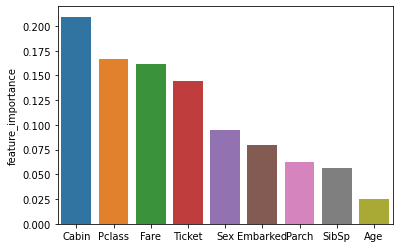

In [99]:
df_feature = pd.DataFrame(model.feature_importances_, index=FEATURE_COLS, columns=['feature_importance'])
df_feature.sort_values(by='feature_importance', ascending=False, inplace=True)
sns.barplot(x=df_feature.index, y=df_feature['feature_importance'], data=df_feature)

/var/folders/6n/p34gc5p96tzf37x42n2yk9s4tprcjx/T/ipykernel_68085/219197532.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(FEATURE_COLS)


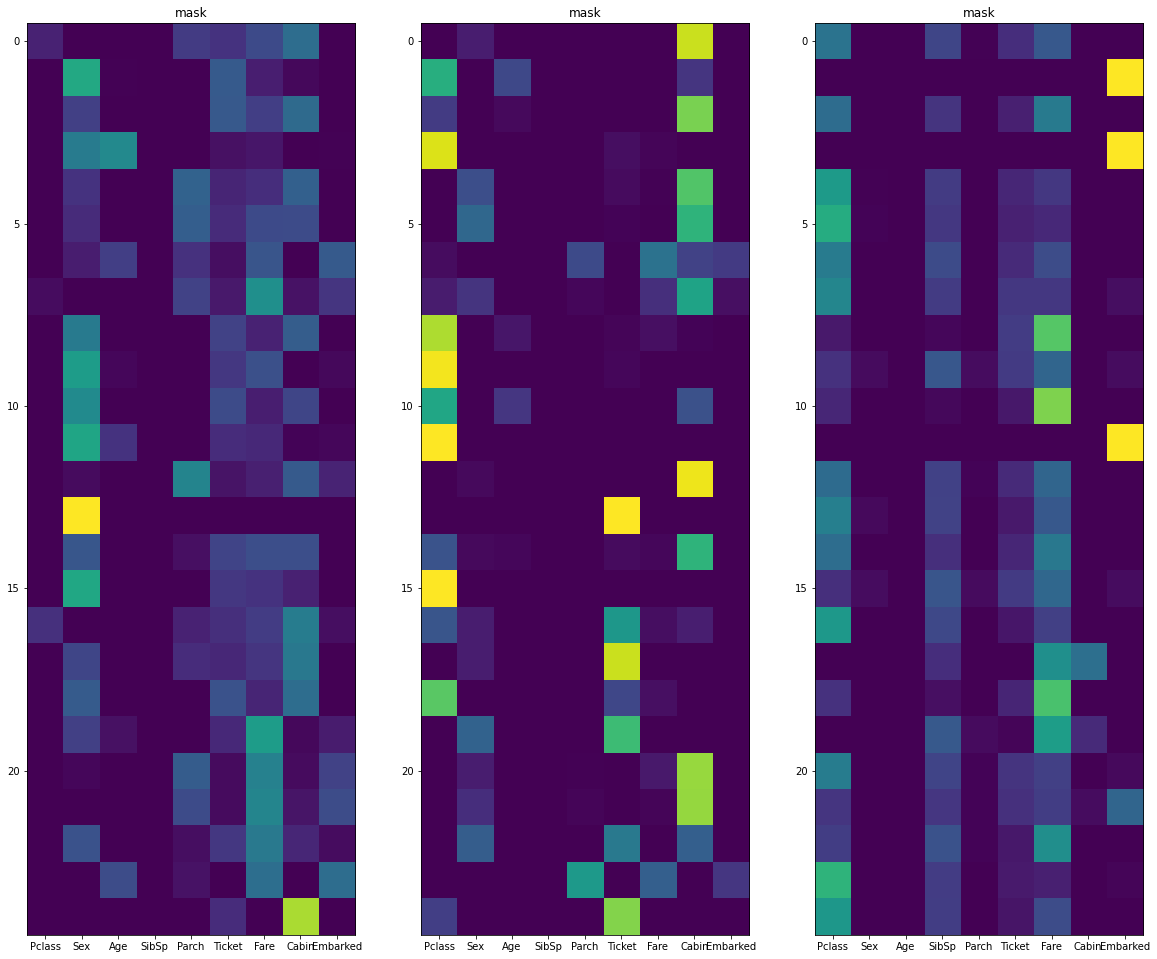

In [110]:
# Mask(Local interpretability)
# このMaskはdecision（どの特徴量を使うか決定）するたびに作成される
# 横軸は特徴量

explain_matrix, masks = model.explain(X_valid)

fig, axs = plt.subplots(1, N_STEPS, figsize=(20, 20))

for i in range(N_STEPS):
    axs[i].imshow(masks[i][:25])
    axs[i].set_title('mask'.format(i))
    axs[i].set_xticklabels(FEATURE_COLS)
    axs[i].xaxis.set_major_locator(ticker.FixedLocator(range(len(FEATURE_COLS))))